In [1]:
import sys
sys.path.append('..')
sys.path.append('.')

import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import utils
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling, diagnostic, tworound_potts

from matplotlib import cm
import pickle

import tworound_potts

import logomaker
import pandas as pd

/home/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id_idx = 0
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
experiment_id = experiment_ids[experiment_id_idx]
round_ids = ["ARN", "R01", "R02N"]

In [3]:
dtype = torch.float32
device = utils.best_device()

Selected device: cuda


In [4]:
(sequences, sequences_unique, counts, log_multinomial_factors, 
 sequences_unique_all, counts_unique) = \
    utils.sequences_from_files_detailed(experiment_id, round_ids)

Extracting sequences from 3 files...
Finished round ARN
Finished round R01
Finished round R02N
Merging sequences from all rounds in a single container...
Assigning counts at each round to unique sequences...
	Starting round ARN...
	Starting round R01...
	Starting round R02N...
Finished


In [5]:
train_valid_idx = torch.load(f'saved/train_test_split/{experiment_id}.pt')
idx_train = train_valid_idx['idx_train']
idx_valid = train_valid_idx['idx_valid']

In [6]:
((sequences_oh, total_reads, log_multinomial_factors), 
 (sequences_valid_oh, total_reads_valid, log_multinomial_factors_valid)) = \
    data_loading.split_train_test(sequences_unique_all, counts_unique, idx_train, idx_valid)

In [7]:
total_reads = total_reads.to(device)
log_multinomial_factors = log_multinomial_factors.to(device)
total_reads_valid = total_reads_valid.to(device)
log_multinomial_factors_valid = log_multinomial_factors_valid.to(device)

In [42]:
data_loaders_valid = [data_loading.SelexRoundDataLoader(seq_oh, device=device) for seq_oh in sequences_valid_oh]

In [8]:
from importlib import reload
reload(energy_models)
reload(utils)
reload(selex_distribution)
reload(training)
reload(callback)
reload(sampling)
reload(diagnostic)
reload(tworound_potts)

<module 'tworound_potts' from '/home/scrotti/Aptamer2025py/experiments/tworound_potts.py'>

## First weight decay


In [45]:
weight_decay = 0
lr = 1e-1
checkpoint_filename = experiment_id + f'_wd_{weight_decay}_SGD'

In [46]:
model, data_loaders, chains, optimizer, log_weights, callbacks = tworound_potts.train_tworound_potts(
    sequences_oh, 
    total_reads, 
    log_multinomial_factors,
    max_epochs = 2,
    weight_decay = weight_decay,
    device = device,
    checkpoint_filename = checkpoint_filename
)

 0.00%[                                                                                                       …

In [78]:
max_epochs = 2*10**3

model, data_loaders, chains, optimizer, log_weights, callbacks = tworound_potts.resume_training(
    model, data_loaders, chains, optimizer, log_weights, callbacks,
    max_epochs, total_reads, log_multinomial_factors)

(callback_convergence, callback_pearson_covariance, 
    callback_checkpoint, callback_params) = callbacks

 0.00%[                                                                                                       …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



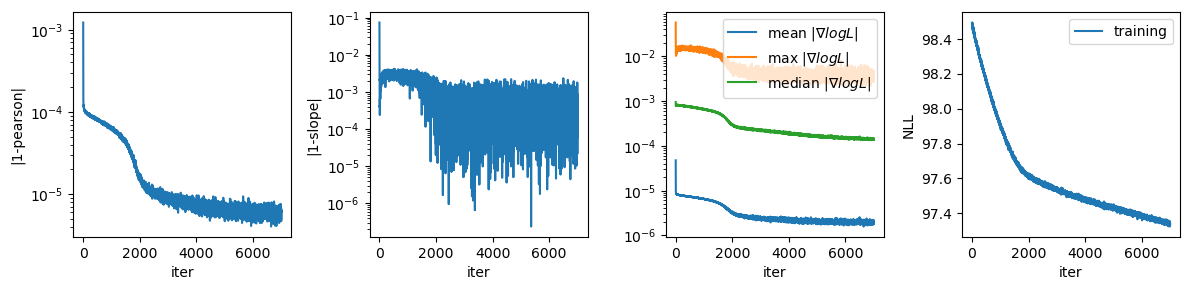

In [79]:
callback_convergence.plot();

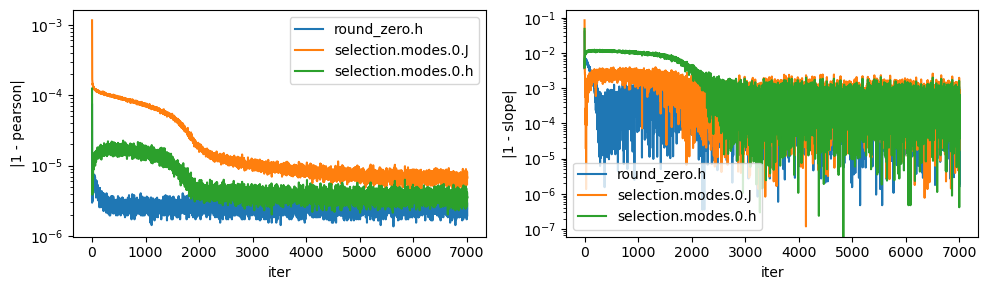

In [80]:
callback_convergence.plot_pearson_detail();

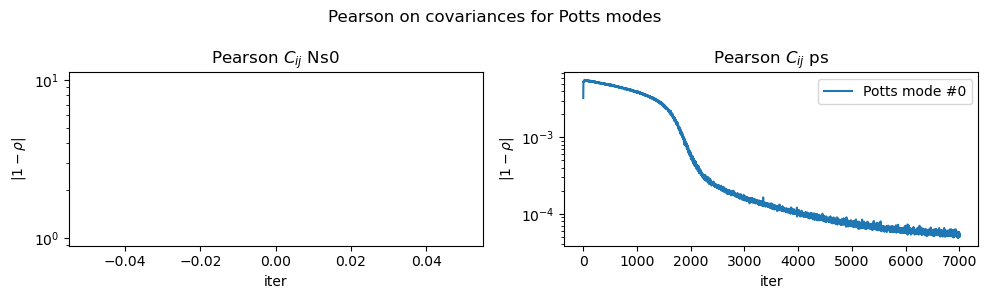

In [81]:
callback_pearson_covariance.plot(figsize=(10,3));

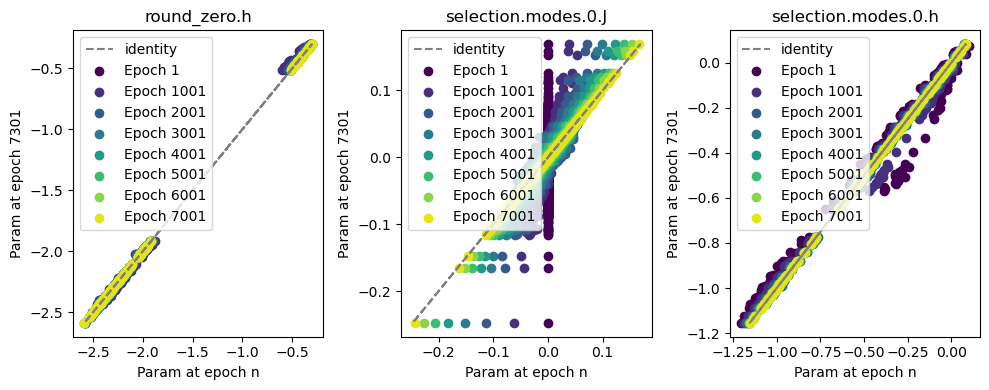

In [82]:
callback_params.plot(plot_every=10);

(0.0, 6.0)

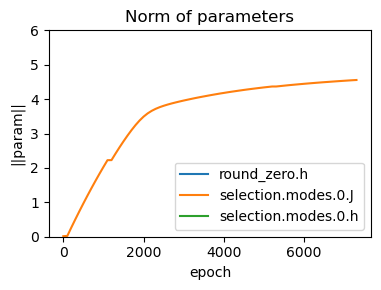

In [83]:
fig, ax = callback_params.plot_norm()
ax.set_ylim((0,6))

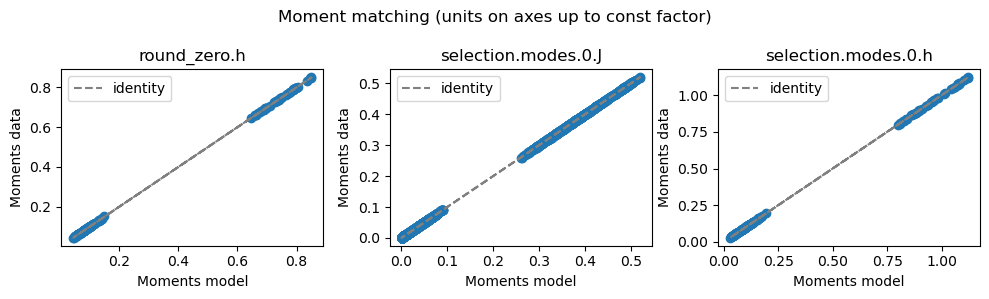

In [84]:
training.scatter_moments(model, data_loaders, chains, total_reads, figsize=(10,3));

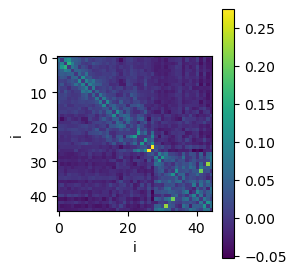

In [85]:
potts_zerosum = model.selection.modes[0].set_zerosum_gauge().cpu()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()

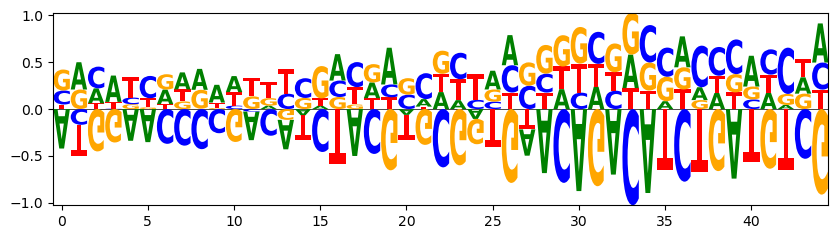

In [86]:
logomaker.Logo(pd.DataFrame(h, columns=list(utils.TOKENS_DNA)));

Computing mixing time for chains initialized at site frequencies


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …


Computing mixing time for chains initialized uniformly


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …


Sampling from the two sets of chains...


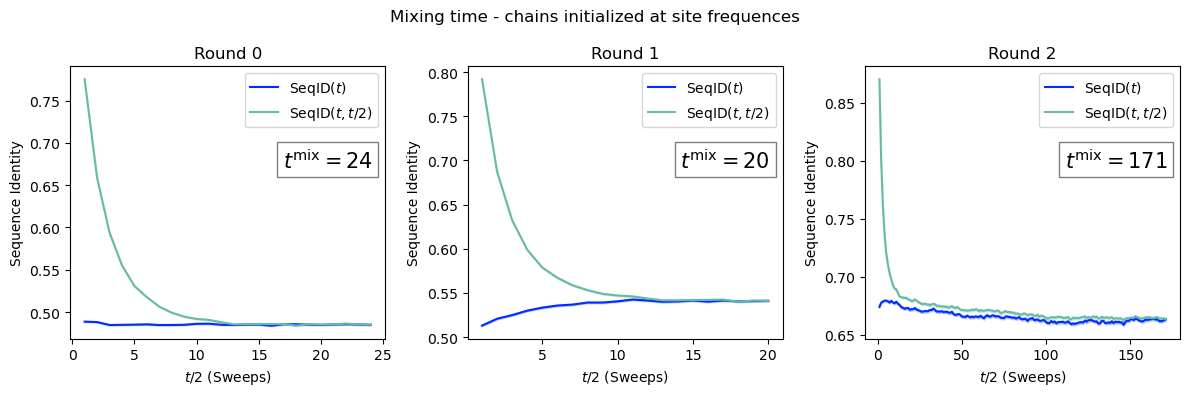

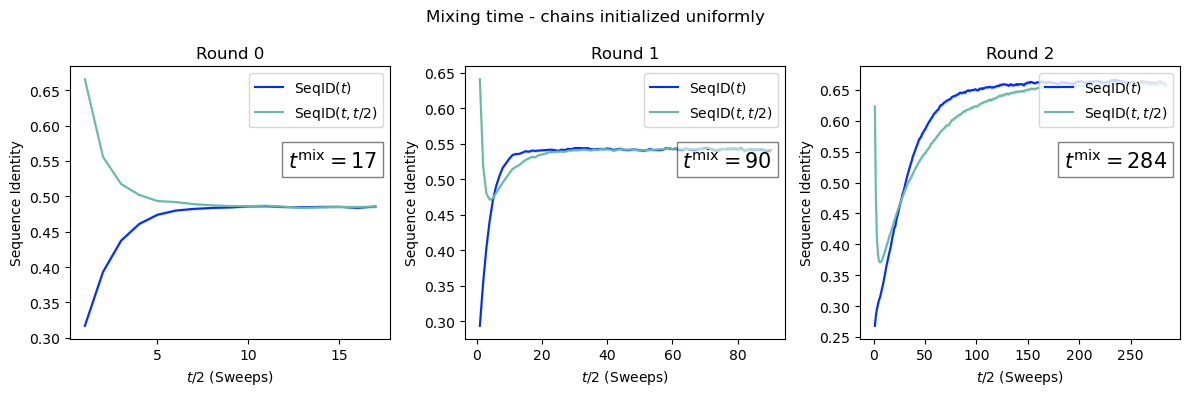

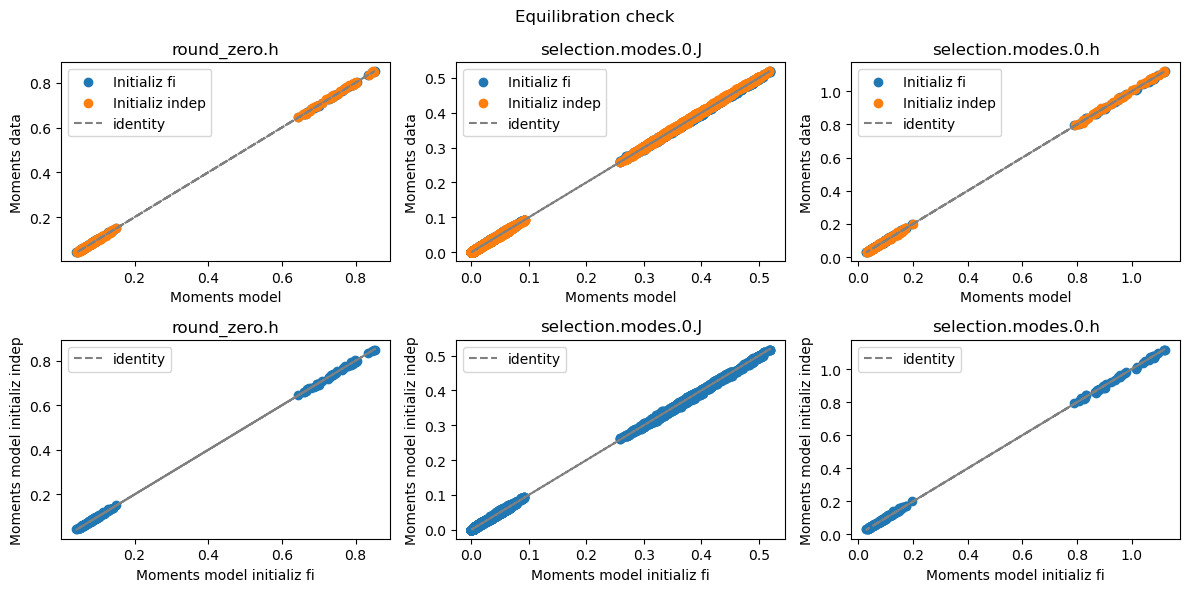

In [87]:
n_chains_equil = 10**4
n_max_sweeps = 10**3

diagnostic.check_equilibration(model, data_loaders, total_reads, 
                                log_multinomial_factors=log_multinomial_factors,
                                n_max_sweeps=n_max_sweeps, n_chains_equil=n_chains_equil, 
                                device=device);

In [88]:
n_chains = 10**4
n_sweeps = 1
step = 0.0001

batches_train = [next(iter(dl)) for dl in data_loaders]
nll_train = - training.estimate_log_likelihood_AIS(model, batches_train, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)

batches_valid = [next(iter(dl)) for dl in data_loaders_valid]
nll_valid = - training.estimate_log_likelihood_AIS(model, batches_valid, total_reads_valid, log_multinomial_factors_valid, n_chains, n_sweeps, step)

nll_train, nll_valid

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

(21.2547664642334, 13.852004051208496)

In [89]:
torch.save(model, f'saved/{checkpoint_filename}.pt')

## Change weight decay

In [90]:
import copy
model_cp = copy.deepcopy(model)

In [91]:
weight_decay = 0.01
lr = 1e-1
checkpoint_filename = experiment_id + f'_wd_{weight_decay}_SGD'

In [92]:
model, data_loaders, chains, optimizer, log_weights, callbacks = tworound_potts.train_tworound_potts(
    sequences_oh, 
    total_reads, 
    log_multinomial_factors,
    max_epochs = 2,
    weight_decay = weight_decay,
    device = device,
    checkpoint_filename = checkpoint_filename
)

 0.00%[                                                                                                       …

In [93]:
max_epochs = 7*10**3

model, data_loaders, chains, optimizer, log_weights, callbacks = tworound_potts.resume_training(
    model, data_loaders, chains, optimizer, log_weights, callbacks,
    max_epochs, total_reads, log_multinomial_factors)

(callback_convergence, callback_pearson_covariance, 
    callback_checkpoint, callback_params) = callbacks

 0.00%[                                                                                                       …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



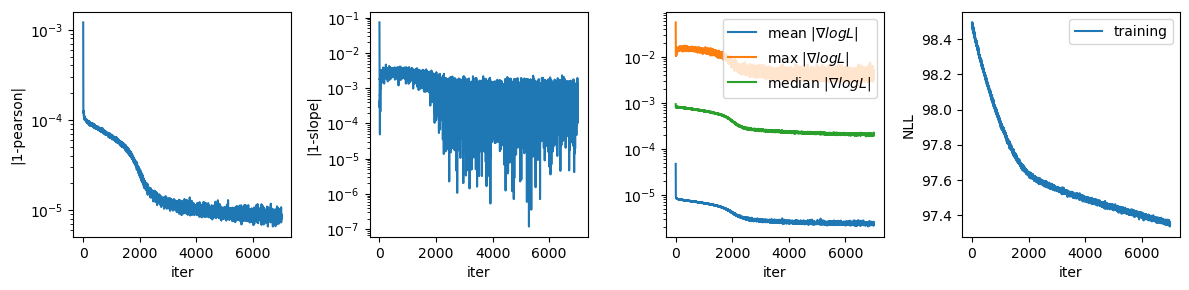

In [94]:
callback_convergence.plot();

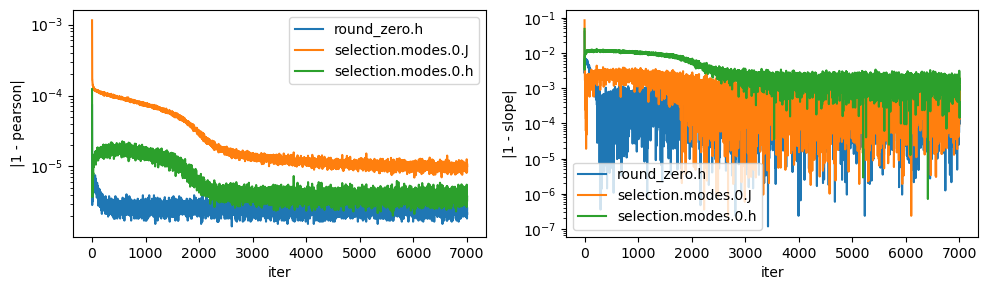

In [95]:
callback_convergence.plot_pearson_detail();

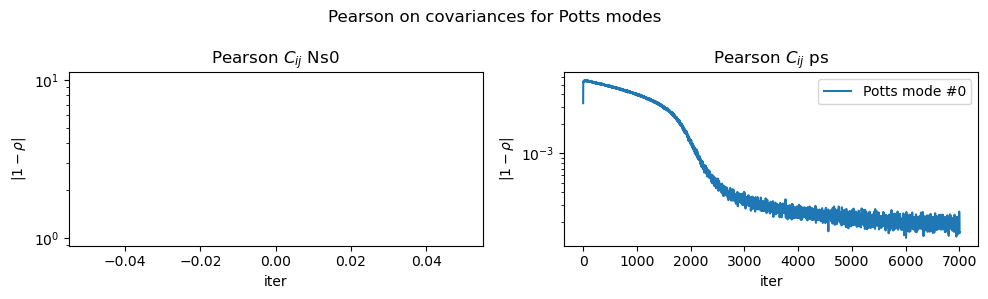

In [96]:
callback_pearson_covariance.plot(figsize=(10,3));

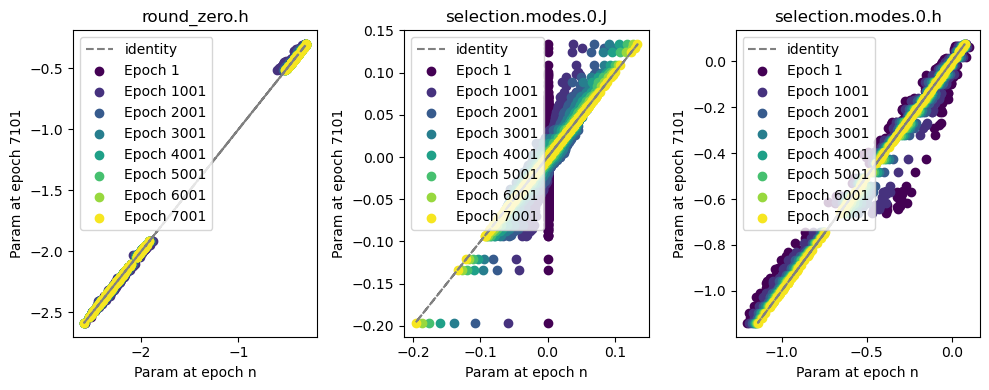

In [97]:
callback_params.plot(plot_every=10);

(0.0, 6.0)

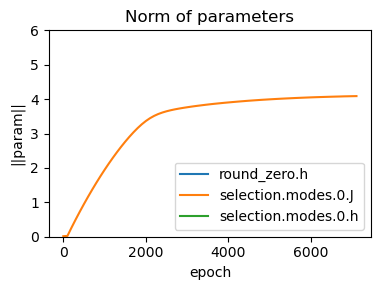

In [98]:
fig, ax = callback_params.plot_norm()
ax.set_ylim((0,6))

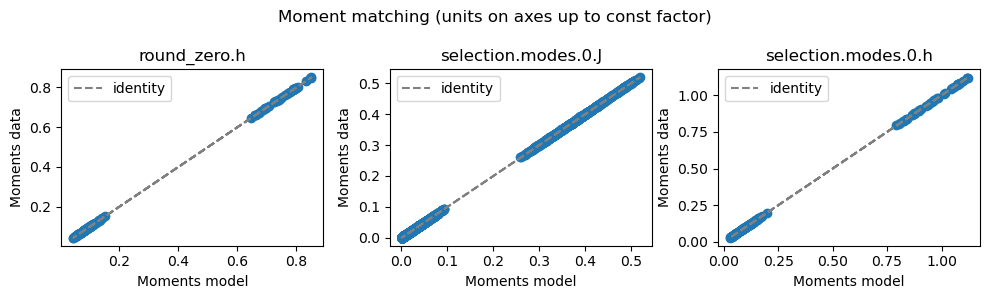

In [99]:
training.scatter_moments(model, data_loaders, chains, total_reads, figsize=(10,3));

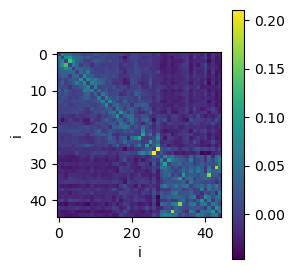

In [100]:
potts_zerosum = model.selection.modes[0].set_zerosum_gauge().cpu()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()

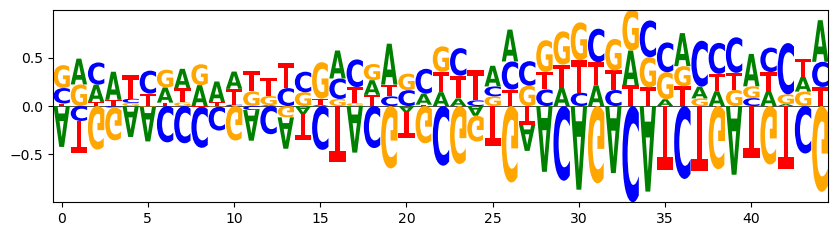

In [101]:
logomaker.Logo(pd.DataFrame(h, columns=list(utils.TOKENS_DNA)));

Computing mixing time for chains initialized at site frequencies


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …


Computing mixing time for chains initialized uniformly


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …


Sampling from the two sets of chains...


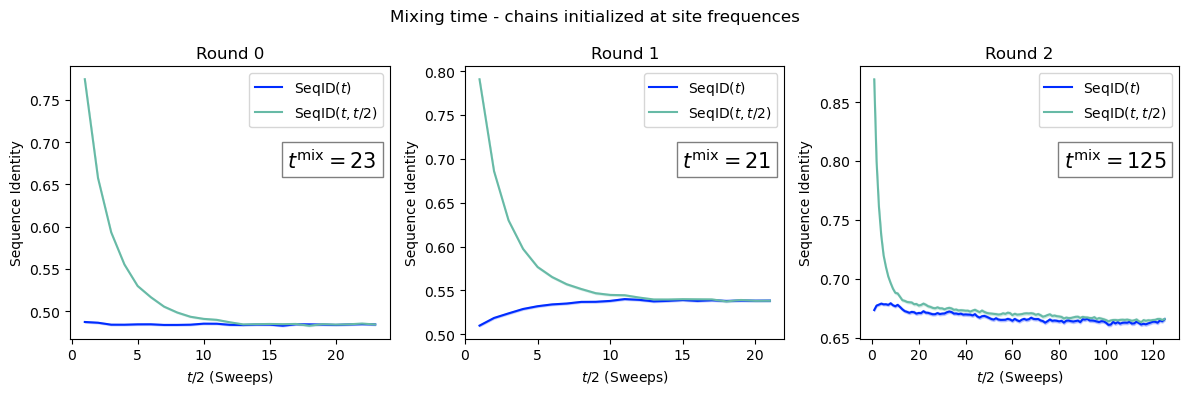

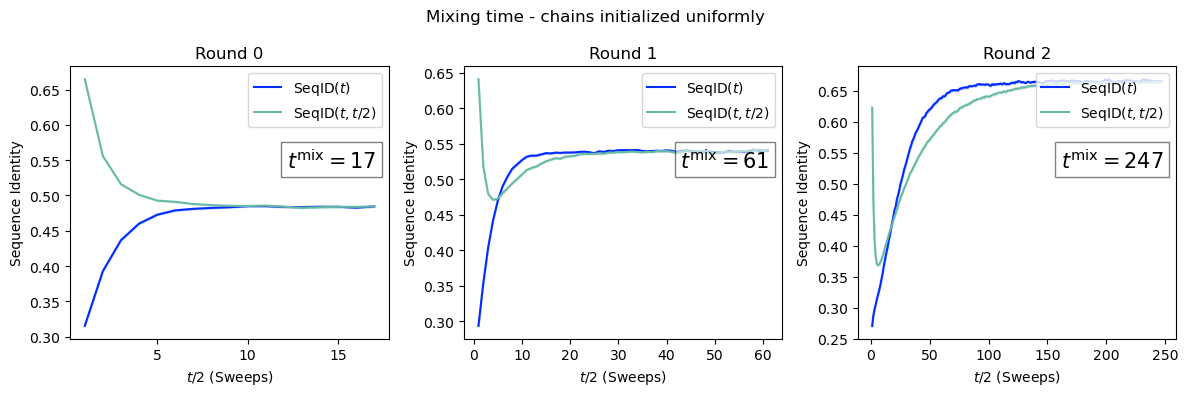

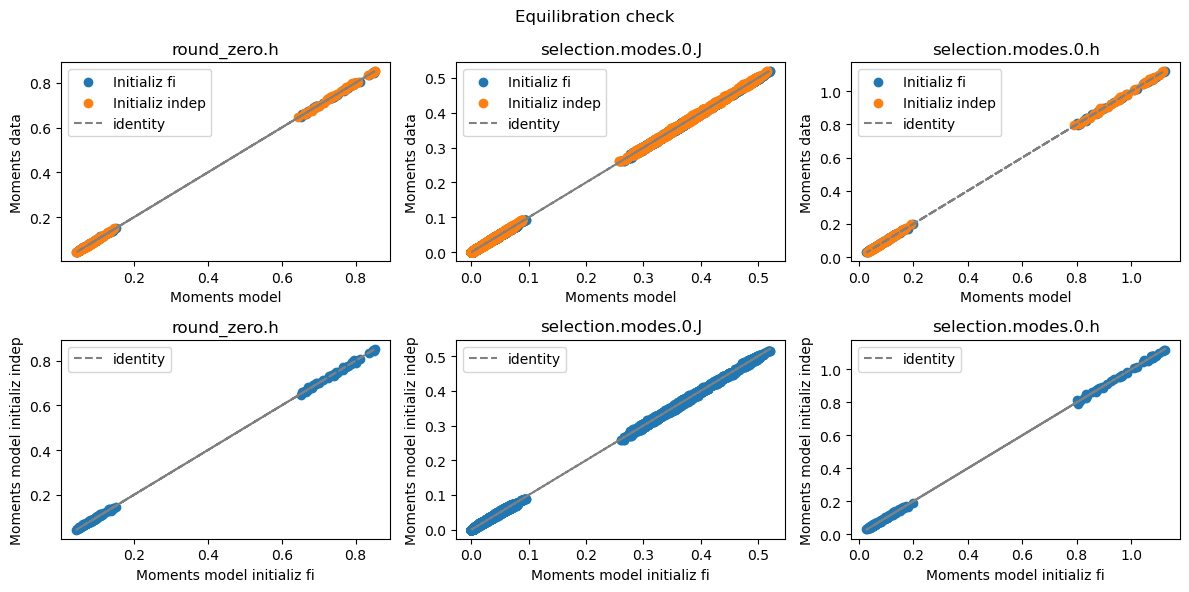

In [102]:
n_chains_equil = 10**4
n_max_sweeps = 10**3

diagnostic.check_equilibration(model, data_loaders, total_reads, 
                                log_multinomial_factors=log_multinomial_factors,
                                n_max_sweeps=n_max_sweeps, n_chains_equil=n_chains_equil, 
                                device=device);

In [103]:
n_chains = 10**4
n_sweeps = 1
step = 0.0001

batches_train = [next(iter(dl)) for dl in data_loaders]
nll_train = - training.estimate_log_likelihood_AIS(model, batches_train, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)

batches_valid = [next(iter(dl)) for dl in data_loaders_valid]
nll_valid = - training.estimate_log_likelihood_AIS(model, batches_valid, total_reads_valid, log_multinomial_factors_valid, n_chains, n_sweeps, step)

nll_train, nll_valid

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

(21.205101013183594, 15.636655807495117)

In [104]:
torch.save(model, f'saved/{checkpoint_filename}.pt')

## Change weight decay

In [105]:
import copy
model_cp2 = copy.deepcopy(model)

In [136]:
weight_decay = 0.1
lr = 1e-1
checkpoint_filename = experiment_id + f'_wd_{weight_decay}_SGD'

In [ ]:
model, data_loaders, chains, optimizer, log_weights, callbacks = tworound_potts.train_tworound_potts(
    sequences_oh, 
    total_reads, 
    log_multinomial_factors,
    max_epochs = 2,
    weight_decay = weight_decay,
    device = device,
    checkpoint_filename = checkpoint_filename
)

In [ ]:
max_epochs = 7*10**3

model, data_loaders, chains, optimizer, log_weights, callbacks = tworound_potts.resume_training(
    model, data_loaders, chains, optimizer, log_weights, callbacks,
    max_epochs, total_reads, log_multinomial_factors)

(callback_convergence, callback_pearson_covariance, 
    callback_checkpoint, callback_params) = callbacks

In [ ]:
callback_convergence.plot();

In [ ]:
callback_convergence.plot_pearson_detail();

In [ ]:
callback_pearson_covariance.plot(figsize=(10,3));

In [ ]:
callback_params.plot(plot_every=10);

In [ ]:
fig, ax = callback_params.plot_norm()
ax.set_ylim((0,6))

In [ ]:
training.scatter_moments(model, data_loaders, chains, total_reads, figsize=(10,3));

In [ ]:
potts_zerosum = model.selection.modes[0].set_zerosum_gauge().cpu()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()

In [ ]:
logomaker.Logo(pd.DataFrame(h, columns=list(utils.TOKENS_DNA)));

In [ ]:
n_chains_equil = 10**4
n_max_sweeps = 10**3

diagnostic.check_equilibration(model, data_loaders, total_reads, 
                                log_multinomial_factors=log_multinomial_factors,
                                n_max_sweeps=n_max_sweeps, n_chains_equil=n_chains_equil, 
                                device=device);

In [ ]:
n_chains = 10**4
n_sweeps = 1
step = 0.0001

batches_train = [next(iter(dl)) for dl in data_loaders]
nll_train = - training.estimate_log_likelihood_AIS(model, batches_train, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)

batches_valid = [next(iter(dl)) for dl in data_loaders_valid]
nll_valid = - training.estimate_log_likelihood_AIS(model, batches_valid, total_reads_valid, log_multinomial_factors_valid, n_chains, n_sweeps, step)

nll_train, nll_valid

In [ ]:
torch.save(model, f'saved/{checkpoint_filename}.pt')

## Change weight decay

In [ ]:
import copy
model_cp3 = copy.deepcopy(model)

In [ ]:
weight_decay = 1.0
lr = 1e-1
checkpoint_filename = experiment_id + f'_wd_{weight_decay}_SGD'

In [ ]:
model, data_loaders, chains, optimizer, log_weights, callbacks = tworound_potts.train_tworound_potts(
    sequences_oh, 
    total_reads, 
    log_multinomial_factors,
    max_epochs = 2,
    weight_decay = weight_decay,
    device = device,
    checkpoint_filename = checkpoint_filename
)

In [ ]:
max_epochs = 7*10**3

model, data_loaders, chains, optimizer, log_weights, callbacks = tworound_potts.resume_training(
    model, data_loaders, chains, optimizer, log_weights, callbacks,
    max_epochs, total_reads, log_multinomial_factors)

(callback_convergence, callback_pearson_covariance, 
    callback_checkpoint, callback_params) = callbacks

In [ ]:
callback_convergence.plot();

In [ ]:
callback_convergence.plot_pearson_detail();

In [ ]:
callback_pearson_covariance.plot(figsize=(10,3));

In [ ]:
callback_params.plot(plot_every=10);

In [ ]:
fig, ax = callback_params.plot_norm()
ax.set_ylim((0,6))

In [ ]:
training.scatter_moments(model, data_loaders, chains, total_reads, figsize=(10,3));

In [ ]:
potts_zerosum = model.selection.modes[0].set_zerosum_gauge().cpu()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()

In [ ]:
logomaker.Logo(pd.DataFrame(h, columns=list(utils.TOKENS_DNA)));

In [ ]:
n_chains_equil = 10**4
n_max_sweeps = 10**3

diagnostic.check_equilibration(model, data_loaders, total_reads, 
                                log_multinomial_factors=log_multinomial_factors,
                                n_max_sweeps=n_max_sweeps, n_chains_equil=n_chains_equil, 
                                device=device);

In [ ]:
n_chains = 10**4
n_sweeps = 1
step = 0.0001

batches_train = [next(iter(dl)) for dl in data_loaders]
nll_train = - training.estimate_log_likelihood_AIS(model, batches_train, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)

batches_valid = [next(iter(dl)) for dl in data_loaders_valid]
nll_valid = - training.estimate_log_likelihood_AIS(model, batches_valid, total_reads_valid, log_multinomial_factors_valid, n_chains, n_sweeps, step)

nll_train, nll_valid

In [ ]:
torch.save(model, f'saved/{checkpoint_filename}.pt')